### Импорт библиотек для работы с бд и дф

In [128]:
import psycopg2
import pandas as pd
import sqlalchemy
import seaborn as sns
import matplotlib.pylab as plt

### Кредиты для коннекта к бд

In [154]:
conn = psycopg2.connect(host="45.134.254.239", port="25432", database="demo", 
                            user="Student_01", password="123456789")

In [155]:
cur = conn.cursor()

In [153]:
cur.close()
conn.close()

### количество рейсов в разрезе модели самолета;

In [107]:
cur = conn.cursor()

cur.execute('''
           SELECT 
            aircraft_code,
            model -> 'ru',
            count(DISTINCT flight_id) as flight_count
            FROM flights l
            left join aircrafts_data r 
            using(aircraft_code)
            GROUP BY aircraft_code, model
            order by flight_count desc
            ''')

results = cur.fetchall()
df = pd.DataFrame(results, columns=['aircraft_code', 'model', 'flight_count'])
df.head()

,aircraft_code,model,flight_count
0,CN1,Сессна 208 Караван,18394
1,CR2,Бомбардье CRJ-200,17920
2,SU9,Сухой Суперджет-100,16870
3,321,Аэробус A321-200,3872
4,733,Боинг 737-300,2522


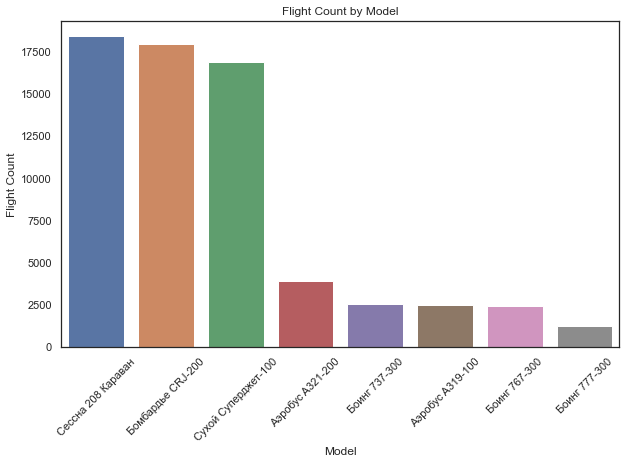

In [108]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="model", y="flight_count")
plt.title('Flight Count by Model')
plt.xlabel('Model')
plt.ylabel('Flight Count')
plt.xticks(rotation=45)
plt.show()

### количество запланированных рейсов по датам

In [109]:
cur.execute('''
select 
date_trunc('day',scheduled_departure)::date,
count(flight_id) as flight_count
from flights f 
where status = 'Scheduled'
group by date_trunc('day',scheduled_departure)
order by date_trunc('day',scheduled_departure)
            ''')

results = cur.fetchall()
df = pd.DataFrame(results, columns=['scheduled_departure', 'flight_count'])
df.head()

,scheduled_departure,flight_count
0,2017-08-16,48
1,2017-08-17,549
2,2017-08-18,493
3,2017-08-19,569
4,2017-08-20,557


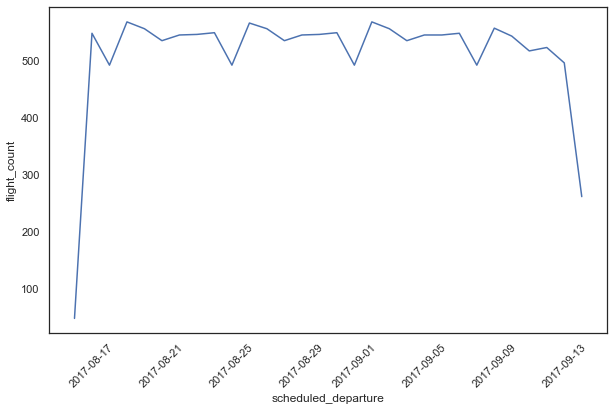

In [110]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="scheduled_departure", y="flight_count")
plt.xticks(rotation=45)
plt.show()

### топ аэропортов по количеству прилетающих рейсов

In [105]:
cur.execute('''
select 
departure_airport,
airport_name -> 'ru',
city -> 'ru',
count(*) as flight_count
from flights l
left join airports_data r 
on l.departure_airport = r.airport_code 
where status = 'Arrived'
group by 
departure_airport,
airport_name,
city
order by flight_count desc 
            ''')

results = cur.fetchall()
df = pd.DataFrame(results, columns=['departure_airport', 'airport_name', 'city', 'flight_count'])
df.head()

,departure_airport,airport_name,city,flight_count
0,DME,Домодедово,Москва,4776
1,SVO,Шереметьево,Москва,4432
2,LED,Пулково,Санкт-Петербург,2825
3,VKO,Внуково,Москва,2555
4,OVB,Толмачёво,Новосибирск,1571


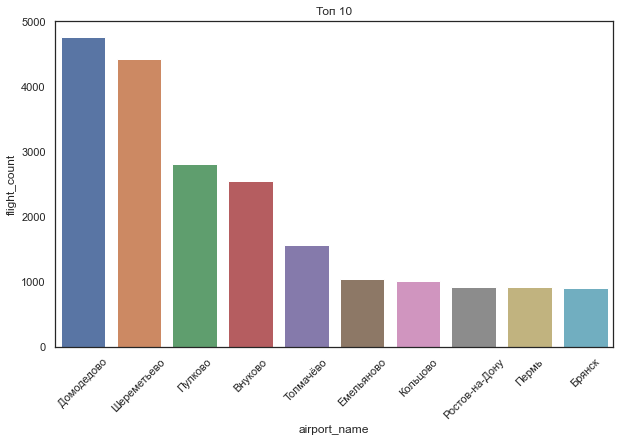

In [106]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df.head(10), x="airport_name", y="flight_count")
plt.title('Топ 10')
plt.xticks(rotation=45)
plt.show()

### средняя загруженность самолётов по типам воздушных судов  с накоплением

In [164]:
cur.execute('''

select 
aircraft_code,
coalesce(round(avg(sum(ticket_count)) over (partition by aircraft_code order by date_trunc('day', scheduled_departure)::date )), 0) as avg_ticket_count_sum,
date_trunc('day', scheduled_departure)::date as scheduled_departure
from flights l
left join 
(select 
l.flight_id,
count(*) as ticket_count
from ticket_flights l
group by flight_id) as r
using(flight_id)
group by date_trunc('day', scheduled_departure)::date, aircraft_code
order by aircraft_code, scheduled_departure

            ''')

results = cur.fetchall()
df =pd.DataFrame(results, columns=['aircraft_code', 'avg_ticket_count_sum', 'scheduled_departure'])
df.head()

,aircraft_code,avg_ticket_count_sum,scheduled_departure
0,319,0,2017-05-16
1,319,389,2017-05-17
2,319,462,2017-05-18
3,319,468,2017-05-19
4,319,505,2017-05-20


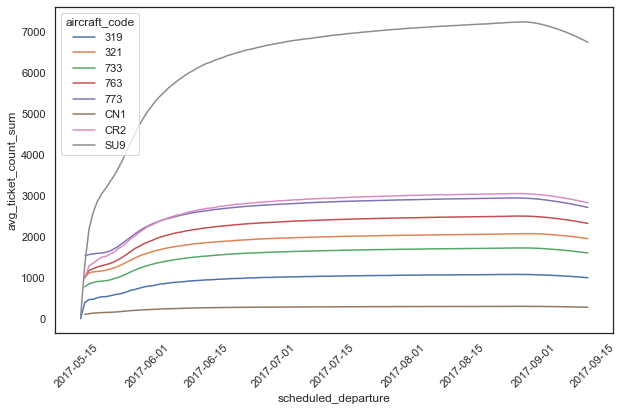

In [165]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='scheduled_departure', y='avg_ticket_count_sum', hue='aircraft_code', 
             data=df)
plt.xticks(rotation=45)
plt.show()

### ранжирование аэропортов по средней задержке вылета

In [122]:
cur.execute('''

select 
departure_airport,
minutes,
dense_rank() over (order by minutes) as dense_rank
from 
(
select 
departure_airport,
round(extract(epoch from avg(actual_departure - scheduled_departure)) / 60) as minutes
from flights f 
where 
scheduled_departure < actual_departure
group by departure_airport
) as a
            ''')

results = cur.fetchall()
df = pd.DataFrame(results, columns=['departure_airport', 'minutes', 'dense_rank'])
df.head()

,departure_airport,minutes,dense_rank
0,USK,3,1
1,OSW,5,2
2,UKX,6,3
3,KYZ,6,3
4,EYK,6,3


In [127]:
plt.figure(figsize=(200, 100))
sns.barplot(data=df, x="departure_airport", y="dense_rank")
plt.xticks(rotation=45)
plt.show()